<br>
<img src="https://sites.google.com/a/chesterqualls.com/chester-qualls-is-it/ChesterQualls%20Logo%28small%29.png?revision=2">
<br>
***
# Natural Language Lab with Bible (Gensim and Wordcloud)

> * Pull in text and play
* Use some of what I learned at SQLSaturday, thank you Yueying Li


In [3]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import nltk

print('done')

done


In [4]:
#Import additional lib's from Li example

import logging, warnings
warnings.filterwarnings('ignore')
from gensim import corpora, utils
from gensim.models.wrappers.dtmmodel import DtmModel
from gensim.models.ldaseqmodel import LdaSeqModel
from gensim.parsing.preprocessing import preprocess_string,strip_tags,strip_punctuation,strip_multiple_whitespaces,strip_numeric,remove_stopwords,strip_short,stem_text
from collections import Counter
from datetime import datetime
from gensim.models.ldamulticore import LdaMulticore
import numpy as np; np.random.seed(0)
import re
import wordcloud
from gensim.models.coherencemodel import CoherenceModel
from nltk import ngrams
from nltk.stem.snowball import SnowballStemmer

print ('done')

done


In [5]:
#Get Bible text
#source = unbound.biola.edu
#downloaded C:/Users/Documents/ASV Bible/asv_utf8.txt
print('Loading data..')

df_asv = pd.read_csv('https://raw.githubusercontent.com/chesterqualls/NLP/master/ASV%20Bible/asv_utf8.txt',skiprows=7,sep='\t')

print('Done.',df_asv.shape[0],'verses were loaded')
print(df_asv[0:5])
df_asv['text'][593]

Loading data..
Done. 31103 verses were loaded
  orig_book_index  orig_chapter  orig_verse  orig_subverse  order_by  \
0             01O             1           1            NaN        10   
1             01O             1           2            NaN        20   
2             01O             1           3            NaN        30   
3             01O             1           4            NaN        40   
4             01O             1           5            NaN        50   

                                                text  
0  In the beginning God created the heavens and t...  
1  And the earth was waste and void; and darkness...  
2  And God said, Let there be light: and there wa...  
3  And God saw the light, that it was good: and G...  
4  And God called the light Day, and the darkness...  


'And Abraham said unto his servant, the elder of his house, that ruled over all that he had, Put, I pray thee, thy hand under my thigh.'

In [6]:
df_asv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31103 entries, 0 to 31102
Data columns (total 6 columns):
orig_book_index    31103 non-null object
orig_chapter       31103 non-null int64
orig_verse         31103 non-null int64
orig_subverse      0 non-null float64
order_by           31103 non-null int64
text               31103 non-null object
dtypes: float64(1), int64(3), object(2)
memory usage: 1.4+ MB


In [7]:
verses = df_asv['text']

# text pre-processing using gensim
CUSTOM_FILTERS = [lambda x: x.lower()
                  , strip_punctuation
                  # optional - might want to keep numbers sometimes
                  , strip_numeric 
                  , remove_stopwords
                  , strip_multiple_whitespaces
                  #removving word of length 1 or 2
                  , strip_short] 

def custom_preprocess_string(x):
    return preprocess_string(x,CUSTOM_FILTERS)

docs=list(map(custom_preprocess_string, verses))
# check the first processed doc
docs = np.array(docs)
print(len(docs),'verses were pre-processed')
docs[593]

31103 verses were pre-processed


['abraham',
 'said',
 'unto',
 'servant',
 'elder',
 'house',
 'ruled',
 'pray',
 'thee',
 'thy',
 'hand',
 'thigh']

In [8]:
# customized my own stop word list
mystop = {'thee','thou','thy','thine','unto','art','hath','hast'}

docs2 = []
for doc in docs:
    doc = [i for i in doc if i not in mystop]
    docs2.append(doc)

docs = docs2
print(docs[593])

['abraham', 'said', 'servant', 'elder', 'house', 'ruled', 'pray', 'hand', 'thigh']


In [9]:
df_asv['docs'] = docs
df_asv['len']=list(map(len,df_asv['docs']))
real_asv=df_asv[df_asv['len']>0]
real_asv = real_asv['docs']
print(len(real_asv),'verses were left not empty')
real_asv[0:5]

31102 verses were left not empty


0            [beginning, god, created, heavens, earth]
1    [earth, waste, void, darkness, face, deep, spi...
2                       [god, said, let, light, light]
3    [god, saw, light, good, god, divided, light, d...
4    [god, called, light, day, darkness, called, ni...
Name: docs, dtype: object

# Word Cloud
* Some documentation for this word cloud code https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html

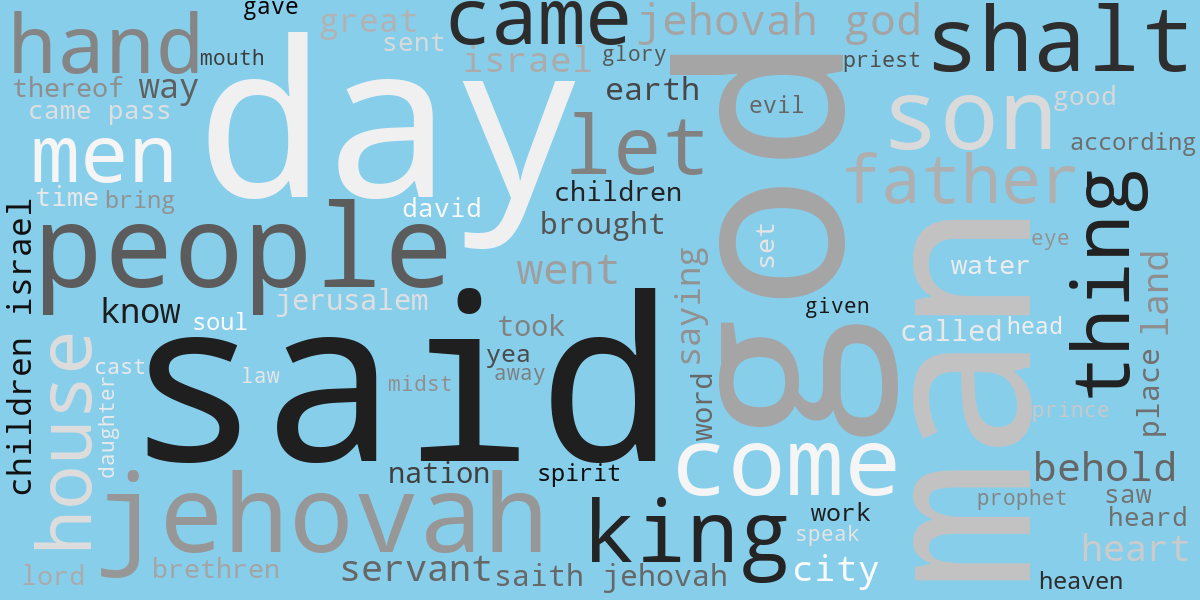

In [10]:
stopwords = wordcloud.STOPWORDS
stopwords.update(())

word_string = [' '.join(word) for word in real_asv]
word_string = ' '.join(word_string)
# Generate a word cloud image
cloud = wordcloud.WordCloud(height=600
                                , width=1200
                                , max_words=75
                                , colormap="Greys"
                                , background_color="#87CEEB"
                                , relative_scaling=.75
                                , collocations = True).generate(word_string)

# Display the generated image:

cloud.to_image()

# Latent Dirichlet Allocation (LDA)

* Wikipedia Article: https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation
* Information about LDA in Gensim: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
* Interesting Tips for LDA in Gensim: https://miningthedetails.com/blog/python/lda/GensimLDA/

> LDA is a way to determine the n core topics from a corpus of text. The methods are explained in the Wikipedia article above. <br><br>
The pyLDAvis visualization tool used requires loading that library which is done below rather than at the beginning of this notebook.<br><br>
Begin with filtering the corpus to remove tokens that exist infrequent.  

In [11]:
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(real_asv)
print('There are total',len(dictionary),'words after pre-processing')
# Filter out words that occur less than 2 documents, or more than 99% of all the documents.
dictionary.filter_extremes(no_below=2, no_above=0.99) 
print('There are total',len(dictionary),'words after filtering')
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
corpus = [dictionary.doc2bow(doc) for doc in real_asv]

There are total 12019 words after pre-processing
There are total 8252 words after filtering


In [46]:
# Run data through LDA
#Latent Dirichlet Allocation (LDA) which provides topic modeling based on word frequency
t1=datetime.now()

print('Running LDA Model..')

lda = LdaMulticore(corpus
                   , id2word=dictionary
                   , workers=3
                   , iterations=100
                   , num_topics=76
                   , random_state=np.random.RandomState(seed=1254)
                   , chunksize = 100
                   , passes=1)

print('Run time for the LDA model with', len(real_asv) ,'Bible verses:', datetime.now()-t1 )

Running LDA Model..
Run time for the LDA model with 31102 Bible verses: 0:00:17.542846


In [47]:
# print topics from the lda model
data = lda.print_topics(-1,num_words=10)

#Show Topics
d = {}
for i, y in data:
    d['Topic {}'.format(i)] = re.findall('"(.*?)"',y)
    
df1 = pd.DataFrame(d)
print(df1)

     Topic 0       Topic 1 Topic 10  Topic 11  Topic 12 Topic 13   Topic 14  \
0       lord       kingdom    shall      dead       son    earth      place   
1       said         shall    works      body     power     head    eternal   
2   answered     beginning     land     peter      sons   spoken      anger   
3  righteous         sheep    egypt    mother     chief     able       wind   
4        god         flock   perish      gold  daughter  heavens     better   
5     wicked          hair   reason    silver     asked    image       vain   
6      judge       exalted  perfect     house     tribe   poured     taketh   
7       long        months  vessels      fast   solomon      oil        god   
8    jehovah  accomplished   chosen     leave      wife    birds  justified   
9        far    acceptable   walked  neighbor    daniel     sold    looking   

    Topic 15  Topic 16   Topic 17     ...     Topic 69  Topic 7     Topic 70  \
0  according     death    nations     ...        g

In [48]:
#visualizing topics
warnings.filterwarnings('ignore')
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda, corpus, dictionary)

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
45     2.526160        1       1  0.079494  0.028468
12     2.480018        1       2  0.076578 -0.133116
47     2.364413        1       3  0.089192 -0.044003
40     2.275782        1       4 -0.045820  0.020338
56     2.048742        1       5 -0.195433 -0.035119
0      1.958572        1       6  0.026899  0.184648
10     1.894815        1       7 -0.213831 -0.037882
42     1.856930        1       8 -0.191319 -0.017346
29     1.744383        1       9  0.032500  0.157508
62     1.725437        1      10 -0.147247  0.074898
30     1.683347        1      11  0.030628 -0.161269
21     1.674572        1      12 -0.205948  0.034147
66     1.628955        1      13  0.071536 -0.016540
52     1.621003        1      14  0.099551  0.125372
20     1.610028        1      15  0.086876 -0.093886
25     1.608095        1      16  0.019300  0.110163
35     1.594844        1      17  0.083922 -0.026393
24     1.592421        1      18  0.105475  0.121366
7      1.562333        1      19  0.057045  0.098566
63     1.525994        1      20  0.019439  0.141763
23     1.520764        1      21 -0.216151 -0.031096
9      1.469349        1      22 -0.123418  0.043523
51     1.463049        1      23  0.053115  0.103099
16     1.454749        1      24 -0.120060 -0.041673
55     1.446259        1      25  0.067303  0.010032
11     1.425996        1      26 -0.036175 -0.072233
2      1.420513        1      27 -0.117104  0.004043
69     1.401494        1      28  0.018854 -0.020352
57     1.372291        1      29  0.083888  0.042572
75     1.359943        1      30  0.074333 -0.088443
...         ...      ...     ...       ...       ...
26     1.130843        1      47  0.087341  0.022893
61     1.130397        1      48 -0.036936 -0.017520
73     1.121742        1      49  0.069286 -0.061637
68     1.094382        1      50 -0.020891  0.097468
1      1.058935        1      51 -0.200752 -0.079877
34     1.051920        1      52 -0.143274  0.012514
15     1.038000        1      53  0.057642 -0.167496
65     1.033296        1      54  0.031253  0.013595
4      1.016572        1      55 -0.027105 -0.009446
49     0.977058        1      56  0.100127  0.039871
39     0.973412        1      57 -0.060115 -0.112659
70     0.971232        1      58  0.090070 -0.048665
17     0.962480        1      59  0.059637 -0.047970
3      0.961706        1      60 -0.074330  0.083054
46     0.961148        1      61  0.085703  0.052073
67     0.954938        1      62 -0.115728  0.039320
48     0.946720        1      63  0.019835 -0.019338
38     0.935465        1      64 -0.030314 -0.053973
54     0.934927        1      65 -0.061228 -0.046671
60     0.927027        1      66 -0.046725  0.045762
31     0.923075        1      67 -0.006757  0.096022
71     0.920632        1      68  0.055744 -0.066748
59     0.910602        1      69  0.048081 -0.024522
28     0.889759        1      70  0.077659 -0.012284
6      0.873895        1      71 -0.059661  0.019990
72     0.870516        1      72  0.067860 -0.105058
33     0.834099        1      73  0.076049 -0.026786
18     0.816890        1      74 -0.043728 -0.022936
43     0.802749        1      75  0.041727 -0.041242
36     0.722591        1      76  0.056302 -0.097403

[76 rows x 5 columns], topic_info=     Category         Freq          Term        Total  loglift  logprob
term                                                                   
100   Default  8603.000000         shall  8603.000000  30.0000  30.0000
295   Default  2172.000000          come  2172.000000  29.0000  29.0000
1049  Default  1847.000000         saith  1847.000000  28.0000  28.0000
734   Default  2077.000000          king  2077.000000  27.0000  27.0000
90    Default  2963.000000           man  2963.000000  26.0000  26.0000
1520  Default  1934.000000        israel  1934.000000  25.0000  25.0000
83    Default  1705

# Coherence Model
* Some information on Topic Coherence: https://rare-technologies.com/what-is-topic-coherence/
* Wikipedia article on Coherence Theory of Truth with may be related: https://en.wikipedia.org/wiki/Coherence_theory_of_truth
> Used different ranges and values for n topics, then did another to finer granularity. This shows that 70 is better than 60 or 80, but that 76 is the optimal number of topics.

The coherent metric (u_mass) with 10 number of topics: -6.34635986209
The coherent metric (u_mass) with 20 number of topics: -8.47668115649
The coherent metric (u_mass) with 30 number of topics: -10.7922121875
The coherent metric (u_mass) with 40 number of topics: -11.0396562311
The coherent metric (u_mass) with 50 number of topics: -12.4817049676
The coherent metric (u_mass) with 60 number of topics: -12.7386418157
The coherent metric (u_mass) with 70 number of topics: -13.7638418019
The coherent metric (u_mass) with 80 number of topics: -13.4030756646
The coherent metric (u_mass) with 90 number of topics: -10.8684981155
Run time for the LDA model: 21:57:43.283313


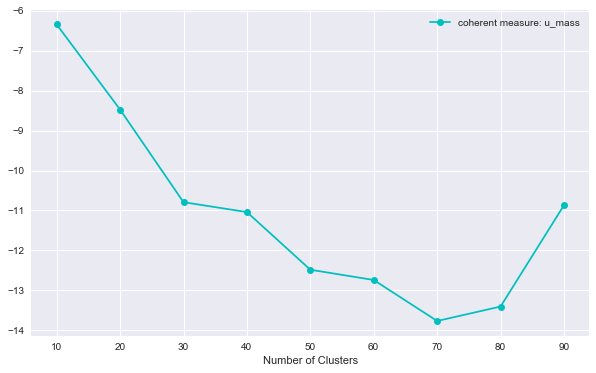

In [45]:
UMs=[]
#topic_vals = [5,10,15,20,25,30,35,40,45]
topic_vals = [10,20,30,40,50,60,70,80,90] #played with different values and ranges
for x in topic_vals:
    lda = LdaMulticore(corpus, id2word=dictionary, workers=3
                                                  ,iterations=200
                                                  ,num_topics=x
                                                  ,random_state=np.random.RandomState(seed=1254)
                                                  ,chunksize = 100
                                                  ,passes=1)
    # Topic quality evaluation
# Topic coherence No.1, using u_mass
    coherenceUM = CoherenceModel(model=lda, corpus=corpus, dictionary=dictionary, coherence='u_mass') # ordered words ~0
# the higher the better
    UM = coherenceUM.get_coherence()
    print('The coherent metric (u_mass) with',x,'number of topics:',UM)
    UMs.append(UM)

t2 = datetime.now()
print('Run time for the LDA model:', t2-t1 )

topic_vals = np.array(topic_vals)

fig1 = plt.figure(figsize=(10,6))
ax1 = fig1.add_subplot(111)
ax1.plot(topic_vals,UMs, label='coherent measure: u_mass', color='c', marker='o')
plt.xticks(topic_vals)
plt.xlabel('Number of Clusters')
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc='upper right', bbox_to_anchor=(1,1))
ax1.grid('on')
plt.show()

The coherent metric (u_mass) with 66 number of topics: -13.5476778637
The coherent metric (u_mass) with 68 number of topics: -13.0694900474
The coherent metric (u_mass) with 70 number of topics: -13.5631355331
The coherent metric (u_mass) with 72 number of topics: -13.9929212467
The coherent metric (u_mass) with 74 number of topics: -13.605245731
The coherent metric (u_mass) with 76 number of topics: -14.3072838078
The coherent metric (u_mass) with 78 number of topics: -14.0000215396
The coherent metric (u_mass) with 80 number of topics: -13.2866438872
Run time for the LDA model: 21:53:48.505419


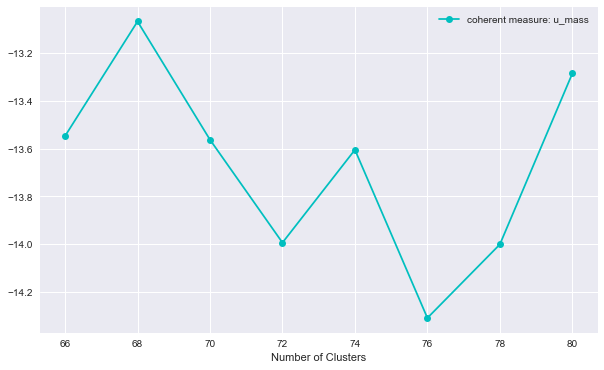

In [44]:
UMs=[]
#topic_vals = [5,10,15,20,25,30,35,40,45]
topic_vals = [66,68,70,72,74,76,78,80]
#topic_vals = [10,20,30,40,50,60,70,80,90] #played with different values and ranges
for x in topic_vals:
    lda = LdaMulticore(corpus, id2word=dictionary, workers=3
                                                  ,iterations=200
                                                  ,num_topics=x
                                                  ,random_state=np.random.RandomState(seed=1254)
                                                  ,chunksize = 100
                                                  ,passes=1)
    # Topic quality evaluation
# Topic coherence No.1, using u_mass
    coherenceUM = CoherenceModel(model=lda, corpus=corpus, dictionary=dictionary, coherence='u_mass') # ordered words ~0
# the higher the better
    UM = coherenceUM.get_coherence()
    print('The coherent metric (u_mass) with',x,'number of topics:',UM)
    UMs.append(UM)

t2 = datetime.now()
print('Run time for the LDA model:', t2-t1 )

topic_vals = np.array(topic_vals)

fig1 = plt.figure(figsize=(10,6))
ax1 = fig1.add_subplot(111)
ax1.plot(topic_vals,UMs, label='coherent measure: u_mass', color='c', marker='o')
plt.xticks(topic_vals)
plt.xlabel('Number of Clusters')
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc='upper right', bbox_to_anchor=(1,1))
ax1.grid('on')
plt.show()

# Stemming

* Wikipedia article: https://en.wikipedia.org/wiki/Stemming

In [35]:
# stemming 
stemmer = SnowballStemmer('english')
docs2 = []
for doc in real_asv:
    doc = [stemmer.stem(w) for w in doc]
    docs2.append(doc)

print(docs2[0])

['begin', 'god', 'creat', 'heaven', 'earth']


In [36]:
print(docs)


[['beginning', 'god', 'created', 'heavens', 'earth'], ['earth', 'waste', 'void', 'darkness', 'face', 'deep', 'spirit', 'god', 'moved', 'face', 'waters'], ['god', 'said', 'let', 'light', 'light'], ['god', 'saw', 'light', 'good', 'god', 'divided', 'light', 'darkness'], ['god', 'called', 'light', 'day', 'darkness', 'called', 'night', 'evening', 'morning', 'day'], ['god', 'said', 'let', 'firmament', 'midst', 'waters', 'let', 'divide', 'waters', 'waters'], ['god', 'firmament', 'divided', 'waters', 'firmament', 'waters', 'firmament'], ['god', 'called', 'firmament', 'heaven', 'evening', 'morning', 'second', 'day'], ['god', 'said', 'let', 'waters', 'heavens', 'gathered', 'place', 'let', 'dry', 'land', 'appear'], ['god', 'called', 'dry', 'land', 'earth', 'gathering', 'waters', 'called', 'seas', 'god', 'saw', 'good'], ['god', 'said', 'let', 'earth', 'forth', 'grass', 'herbs', 'yielding', 'seed', 'fruit', 'trees', 'bearing', 'fruit', 'kind', 'seed', 'thereof', 'earth'], ['earth', 'brought', 'fort

In [37]:
print(docs2)

[['begin', 'god', 'creat', 'heaven', 'earth'], ['earth', 'wast', 'void', 'dark', 'face', 'deep', 'spirit', 'god', 'move', 'face', 'water'], ['god', 'said', 'let', 'light', 'light'], ['god', 'saw', 'light', 'good', 'god', 'divid', 'light', 'dark'], ['god', 'call', 'light', 'day', 'dark', 'call', 'night', 'even', 'morn', 'day'], ['god', 'said', 'let', 'firmament', 'midst', 'water', 'let', 'divid', 'water', 'water'], ['god', 'firmament', 'divid', 'water', 'firmament', 'water', 'firmament'], ['god', 'call', 'firmament', 'heaven', 'even', 'morn', 'second', 'day'], ['god', 'said', 'let', 'water', 'heaven', 'gather', 'place', 'let', 'dri', 'land', 'appear'], ['god', 'call', 'dri', 'land', 'earth', 'gather', 'water', 'call', 'sea', 'god', 'saw', 'good'], ['god', 'said', 'let', 'earth', 'forth', 'grass', 'herb', 'yield', 'seed', 'fruit', 'tree', 'bear', 'fruit', 'kind', 'seed', 'thereof', 'earth'], ['earth', 'brought', 'forth', 'grass', 'herb', 'yield', 'seed', 'kind', 'tree', 'bear', 'fruit', 

# n-grams

* Wikipedia article: https://en.wikipedia.org/wiki/N-gram

In [54]:
#ngram
def my_ngram(tokenized,n):
    grams = list(ngrams(tokenized,n))
    g=[]
    for gram in grams:
        g.append(' '.join(gram))
    return g

docs3 = []
for doc in docs2:
    bigram2 = my_ngram(doc,2)
    bigram3 = my_ngram(doc,3) #added 3 word n-grams
    docs3.append(doc+bigram2+bigram3)

print(docs3[0:2])

[['begin', 'god', 'creat', 'heaven', 'earth', 'begin god', 'god creat', 'creat heaven', 'heaven earth', 'begin god creat', 'god creat heaven', 'creat heaven earth'], ['earth', 'wast', 'void', 'dark', 'face', 'deep', 'spirit', 'god', 'move', 'face', 'water', 'earth wast', 'wast void', 'void dark', 'dark face', 'face deep', 'deep spirit', 'spirit god', 'god move', 'move face', 'face water', 'earth wast void', 'wast void dark', 'void dark face', 'dark face deep', 'face deep spirit', 'deep spirit god', 'spirit god move', 'god move face', 'move face water']]


In [40]:
real_asv[0]

['beginning', 'god', 'created', 'heavens', 'earth']

# Don't run the next block until I figure out what to do with it.

In [ ]:
# calculate topic distribution

movie_cnt=list(real_df.groupby('year')['tagline'].agg('count'))

# plot 
fig, ax = plt.subplots(figsize=(11,8))

ax.plot(movie_cnt, label='movie counts per year', marker='o')
plt.xlabel('movie tagline distribution over years')

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(1,1))
ax.grid('on')
plt.show()

# Dynamic Topic Model

* Wikipedia article: https://en.wikipedia.org/wiki/Dynamic_topic_model
* Gensim DTM Model: https://radimrehurek.com/gensim/models/dtmmodel.html<br>
https://radimrehurek.com/gensim/models/wrappers/dtmmodel.html
